In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy import displacy
from spacy import tokenizer
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LsiModel, TfidfModel
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report

In [2]:
# set plot options
plt.rcParams['figure.figsize'] = (12, 8)
default_plot_color = '#00bfbf'

In [59]:
data = pd.read_csv('fake_news_data.csv')

In [4]:
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            198 non-null    object
 1   text             198 non-null    object
 2   date             198 non-null    object
 3   fake_or_factual  198 non-null    object
dtypes: object(4)
memory usage: 6.3+ KB


Text(0.5, 1.0, 'Count of Article Classification')

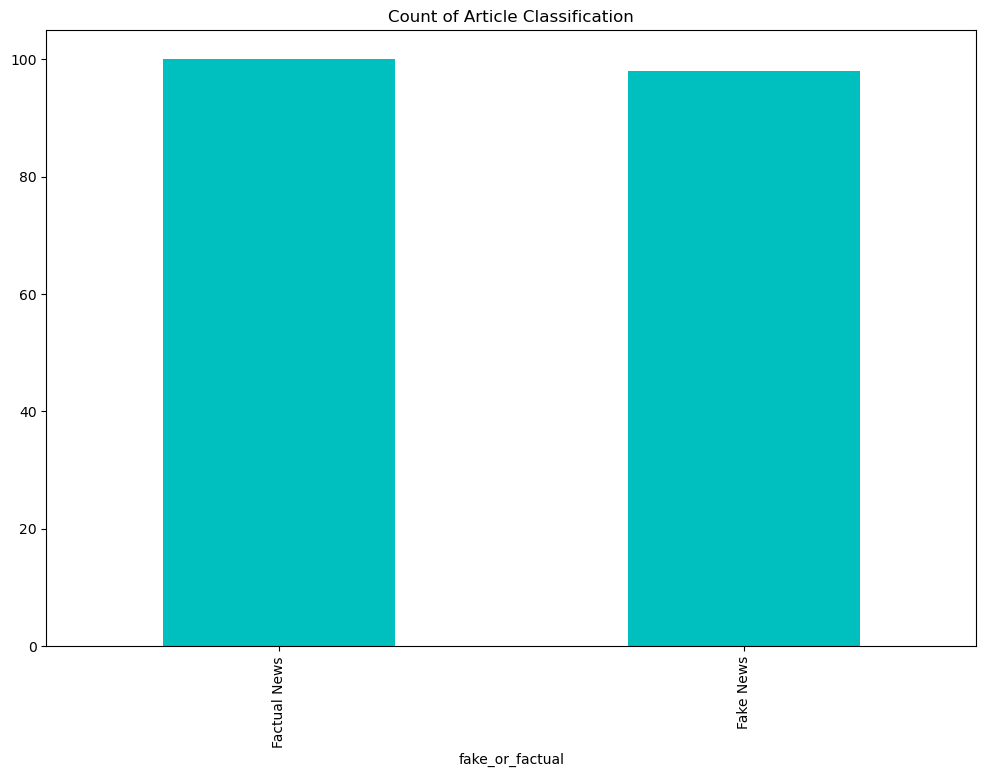

In [6]:
data['fake_or_factual'].value_counts().plot(kind="bar", color=default_plot_color)
plt.title("Count of Article Classification")

## POS Tagging

In [8]:
nlp = spacy.load('en_core_web_sm')

In [9]:
fake_news = data[data['fake_or_factual'] == 'Fake News']
fact_news = data[data['fake_or_factual'] == 'Factual News']

In [10]:
fake_spacydocs = list(nlp.pipe(fake_news['text']))
fact_spacydocs = list(nlp.pipe(fact_news['text']))

In [11]:
def extract_token_tags(doc:spacy.tokens.doc.Doc):
    return [(i.text, i.ent_type_, i.pos_) for i in doc]

In [12]:
fake_tagsdf = []
columns = ["token", "ner_tag", "pos_tag"]

In [13]:
for ix, doc in enumerate(fake_spacydocs):
    tags= extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fake_tagsdf.append(tags)

In [14]:
fake_tagsdf = pd.concat(fake_tagsdf)

In [15]:
fact_tagsdf = []
for ix, doc in enumerate(fact_spacydocs):
    tags= extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fact_tagsdf.append(tags)

fact_tagsdf = pd.concat(fact_tagsdf)

In [16]:
fake_tagsdf.head()

,token,ner_tag,pos_tag
0,There,,PRON
1,are,,VERB
2,two,CARDINAL,NUM
3,small,,ADJ
4,problems,,NOUN


In [17]:
pos_counts_fake = fake_tagsdf.groupby(['token', 'pos_tag']).size().reset_index(name="counts").sort_values(by="counts", ascending=False)
pos_counts_fake.head(10)

,token,pos_tag,counts
29,",",PUNCT,1908
7451,the,DET,1834
41,.,PUNCT,1530
5766,of,ADP,922
2665,and,CCONJ,875
2449,a,DET,805
0,,SPACE,795
7528,to,PART,767
4921,in,ADP,668
5099,is,AUX,419


In [18]:
pos_counts_fact = fact_tagsdf.groupby(['token', 'pos_tag']).size().reset_index(name="counts").sort_values(by="counts", ascending=False)
pos_counts_fact.head(10)

,token,pos_tag,counts
6145,the,DET,1903
14,",",PUNCT,1698
21,.,PUNCT,1382
4716,of,ADP,884
1898,a,DET,789
2093,and,CCONJ,757
4005,in,ADP,671
6205,to,PART,660
4743,on,ADP,482
5567,said,VERB,451


In [19]:
pos_counts_fake.groupby('pos_tag')['token'].count().sort_values(ascending=False).head(10)

pos_tag
NOUN     2586
VERB     1817
PROPN    1672
ADJ       882
ADV       413
NUM       221
PRON       96
ADP        89
AUX        62
SCONJ      51
Name: token, dtype: int64

In [20]:
pos_counts_fact.groupby('pos_tag')['token'].count().sort_values(ascending=False).head(10)

pos_tag
NOUN     2179
VERB     1539
PROPN    1379
ADJ       747
ADV       263
NUM       205
PRON       79
ADP        70
AUX        43
SCONJ      42
Name: token, dtype: int64

In [21]:
pos_counts_fake[pos_counts_fake.pos_tag == "NOUN"][:15]

,token,pos_tag,counts
5981,people,NOUN,77
7349,t,NOUN,65
6216,president,NOUN,58
7960,women,NOUN,55
7516,time,NOUN,52
3138,campaign,NOUN,44
8011,year,NOUN,44
4581,government,NOUN,41
5213,law,NOUN,40
8013,years,NOUN,40


In [22]:
pos_counts_fact[pos_counts_fact.pos_tag == "NOUN"][:15]

,token,pos_tag,counts
3738,government,NOUN,71
6618,year,NOUN,64
5901,state,NOUN,57
2360,bill,NOUN,55
1975,administration,NOUN,51
5066,president,NOUN,49
3277,election,NOUN,48
4919,people,NOUN,45
4786,order,NOUN,45
4259,law,NOUN,42


## Named Entities

In [24]:
top_entities_fake = fake_tagsdf[fake_tagsdf['ner_tag'] != ""].groupby(['token', 'ner_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)

In [25]:
top_entities_fact = fact_tagsdf[fact_tagsdf['ner_tag'] != ""].groupby(['token', 'ner_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)

In [26]:
ner_palette = {
    'ORG': sns.color_palette('Set2').as_hex()[0],
    'GPE': sns.color_palette('Set2').as_hex()[1],
    'NORP': sns.color_palette('Set2').as_hex()[2],
    'PERSON': sns.color_palette('Set2').as_hex()[3],
    'DATE': sns.color_palette('Set2').as_hex()[4],
    'CARDINAL': sns.color_palette('Set2').as_hex()[5],
    'PERCENT': sns.color_palette('Set2').as_hex()[6],
}

[Text(0.5, 1.0, 'Most Common Named Entities in Fake News')]

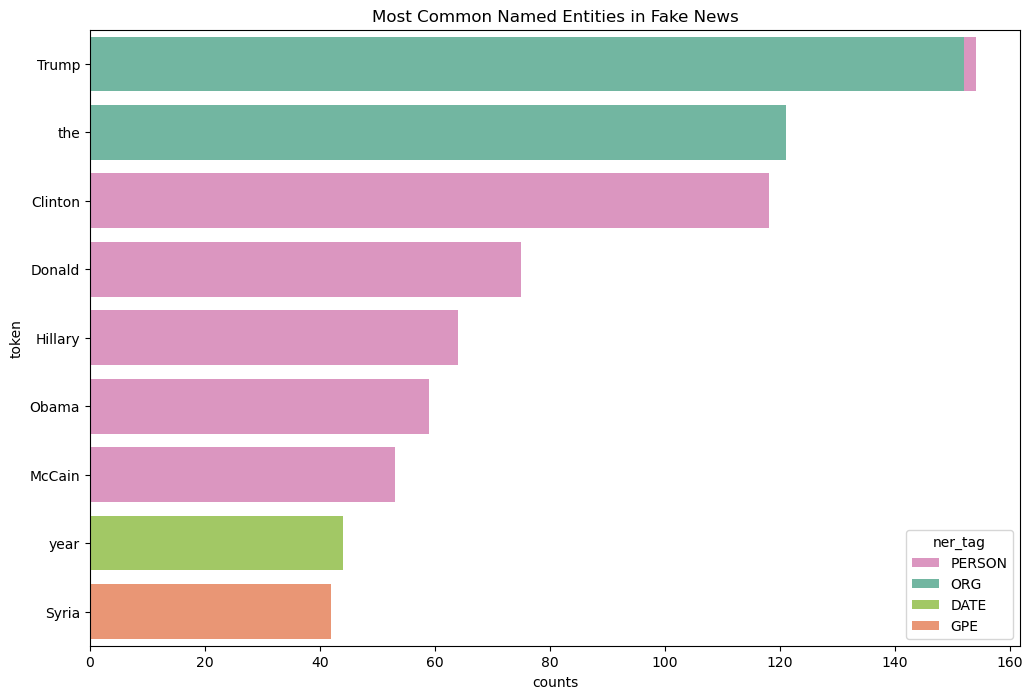

In [27]:
sns.barplot(
    x = "counts",
    y = 'token',
    hue = "ner_tag",
    palette = ner_palette,
    data = top_entities_fake[:10],
    orient = 'h',
    dodge = False
).set(title="Most Common Named Entities in Fake News")

[Text(0.5, 1.0, 'Most Common Named Entities in Factual News')]

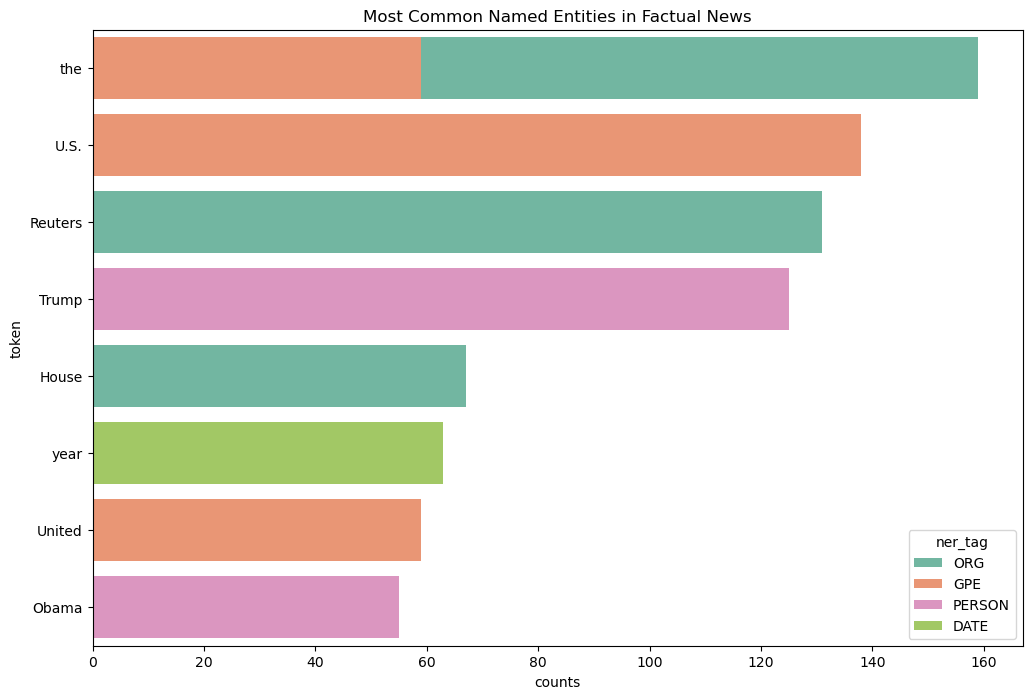

In [28]:
sns.barplot(
    x = "counts",
    y = 'token',
    hue = "ner_tag",
    palette = ner_palette,
    data = top_entities_fact[:10],
    orient = 'h',
    dodge = False
).set(title="Most Common Named Entities in Factual News")

## Text Pre-Processing

In [30]:
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [63]:
data['text_clean'] = data.apply(lambda x: re.sub(r'^[^-]*-\s', "", x['text']), axis=1)

In [65]:
data['text_clean'] = data['text_clean'].str.lower()

In [67]:
data['text_clean'] = data.apply(lambda x: re.sub(r'[^\w\s]', "", x['text_clean']), axis=1)

In [69]:
en_stopwords = stopwords.words('english')
print(en_stopwords)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [71]:
data['text_clean'] = data['text_clean'].apply(lambda x: " ".join([word for word in x.split() if word not in en_stopwords]))

In [73]:
data['text_clean'] = data.apply(lambda x: word_tokenize(x['text_clean']), axis = 1)

In [75]:
lemmatizer = WordNetLemmatizer()
data['text_clean'] = data['text_clean'].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])

In [77]:
data.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m..."
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,..."
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon..."
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,..."


In [79]:
tokens_clean = sum(data['text_clean'], [])

In [81]:
unigrams = (pd.Series(nltk.ngrams(tokens_clean, 1)).value_counts()).reset_index()[:10]
print(unigrams)

           index  count
0        (said,)    580
1       (trump,)    580
2           (u,)    277
3       (state,)    275
4   (president,)    259
5       (would,)    226
6         (one,)    160
7     (clinton,)    141
8        (year,)    139
9  (republican,)    137


/var/folders/w2/wj4jpf295j57b6qtfm43m3gr0000gn/T/ipykernel_9243/452611513.py:3: UserWarning: 
The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


[Text(0.5, 1.0, 'Most Common Unigrams After Processing')]

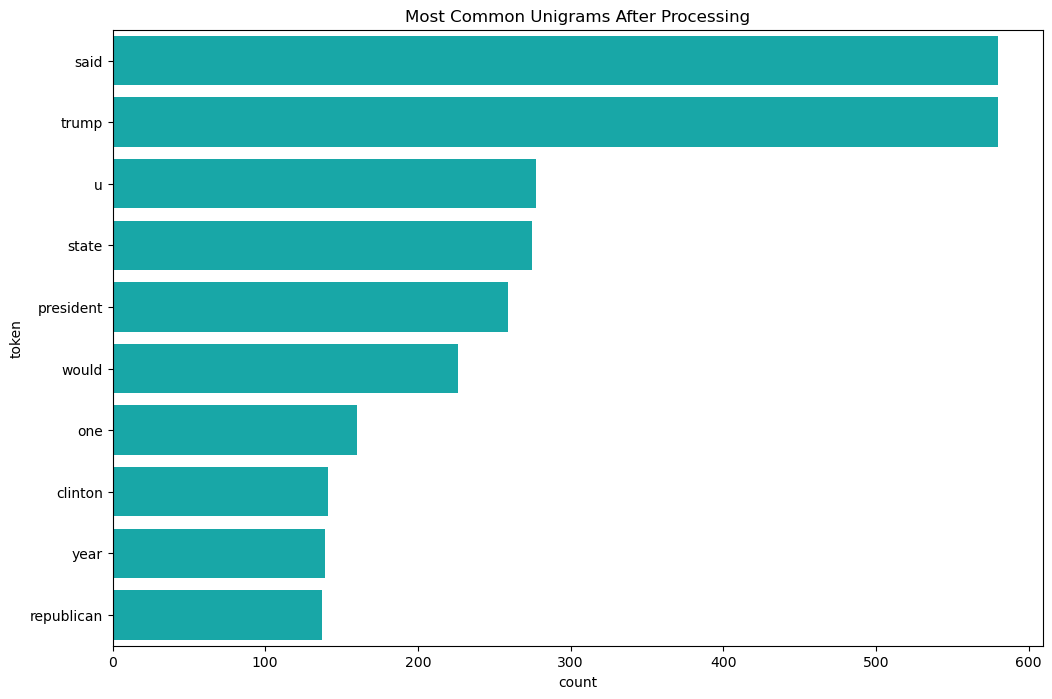

In [83]:
unigrams['token'] = unigrams['index'].apply(lambda x: x[0])

sns.barplot(
    x = "count",
    y = 'token',
    data = unigrams,
    orient = 'h',
    palette = [default_plot_color],
    hue = 'token',
    legend = False
).set(title="Most Common Unigrams After Processing")

In [85]:
bigrams = (pd.Series(nltk.ngrams(tokens_clean, 2)).value_counts()).reset_index()[:10]
print(bigrams)

                     index  count
0          (donald, trump)    113
1          (united, state)     84
2           (white, house)     74
3      (president, donald)     47
4       (hillary, clinton)     39
5              (new, york)     33
6         (supreme, court)     30
7             (image, via)     29
8         (official, said)     26
9  (trump, administration)     26


## Sentiment Analysis

In [88]:
vader_sentiment = SentimentIntensityAnalyzer()

In [90]:
data['vader_sentiment_score'] = data['text'].apply(lambda x: vader_sentiment.polarity_scores(x)['compound'])

In [91]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590


In [92]:
bins = [-1, -0.1, 0.1, 1]
names = ['negative', 'neutral', 'positive']

In [93]:
data['vader_sentiment_label'] = pd.cut(data['vader_sentiment_score'], bins, labels=names)

In [98]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,positive


<Axes: xlabel='vader_sentiment_label'>

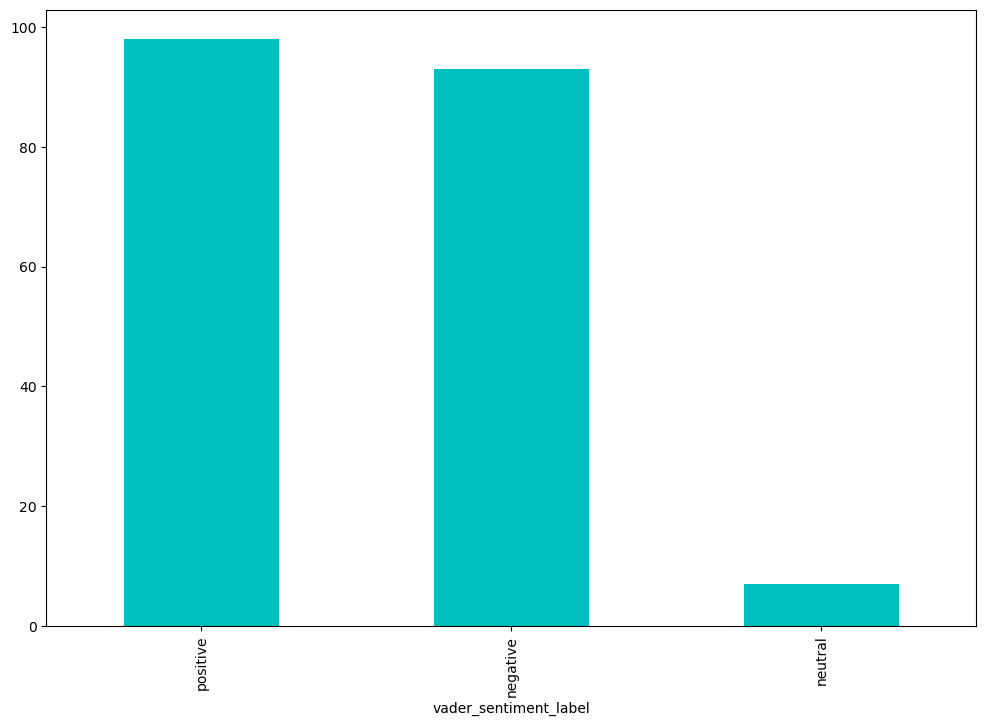

In [100]:
data['vader_sentiment_label'].value_counts().plot.bar(color=default_plot_color)

/var/folders/w2/wj4jpf295j57b6qtfm43m3gr0000gn/T/ipykernel_9243/1764767206.py:1: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.countplot(


[Text(0.5, 1.0, 'Sentiment By News Type')]

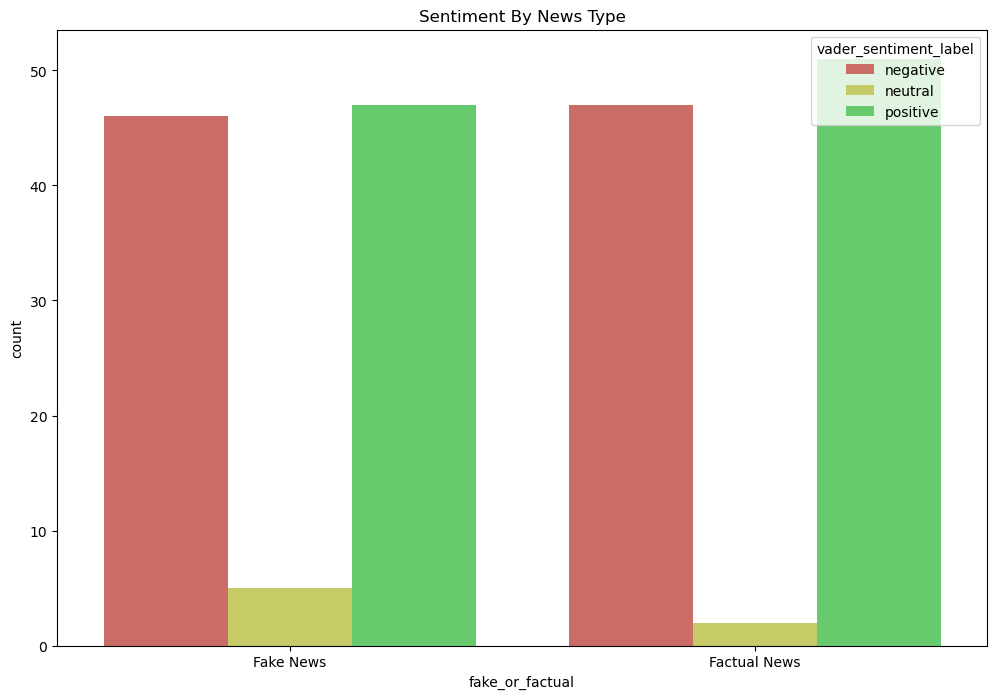

In [102]:
sns.countplot(
    x = 'fake_or_factual',
    hue = 'vader_sentiment_label',
    palette = sns.color_palette('hls'),
    data = data
).set(title='Sentiment By News Type')

## Topic Modeling

In [107]:
fake_news_text = data[data['fake_or_factual'] == 'Fake News']['text_clean'].reset_index(drop=True)

In [109]:
dictionary_fake = corpora.Dictionary(fake_news_text)

In [111]:
doc_term_fake = [dictionary_fake.doc2bow(text) for text in fake_news_text]

In [113]:
coherence_values = []
model_list = []

min_topics = 2
max_topics = 11

for num_topics_i in range(min_topics, max_topics+1):
    model = gensim.models.LdaModel(doc_term_fake, num_topics = num_topics_i, id2word = dictionary_fake)
    model_list.append(model)
    coherence_model = CoherenceModel(model=model, texts=fake_news_text, dictionary=dictionary_fake, coherence='c_v')
    coherence_values.append(coherence_model.get_coherence())

AttributeError: module 'matplotlib.pyplot' has no attribute 'label'

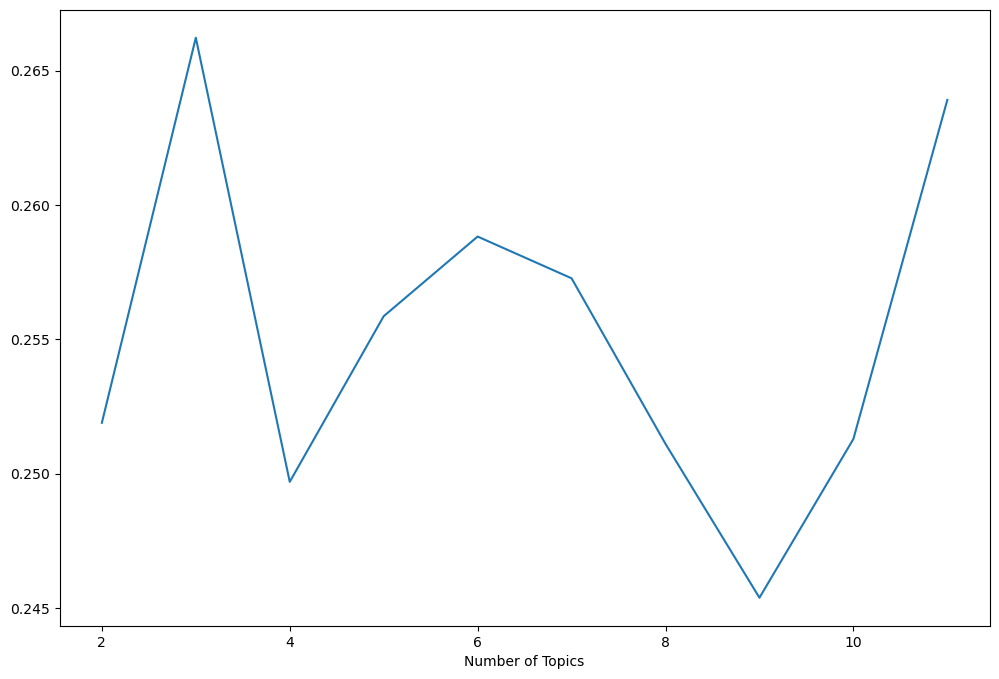

In [114]:
plt.plot(range(min_topics, max_topics+1), coherence_values)
plt.xlabel('Number of Topics')
plt.label('Coherence Scores')
plt.legend('coherence_values', loc='best')
plt.show()

In [124]:
num_topics_lda = 11
lda_model = gensim.models.LdaModel(corpus=doc_term_fake, id2word=dictionary_fake, num_topics = num_topics_lda)

In [126]:
lda_model.print_topics(num_topics = num_topics_lda, num_words=10)

[(0,
  '0.009*"trump" + 0.004*"would" + 0.004*"president" + 0.004*"said" + 0.003*"go" + 0.003*"state" + 0.003*"republican" + 0.003*"obama" + 0.003*"even" + 0.003*"u"'),
 (1,
  '0.020*"trump" + 0.006*"clinton" + 0.005*"said" + 0.005*"one" + 0.005*"donald" + 0.005*"president" + 0.004*"time" + 0.004*"would" + 0.003*"u" + 0.003*"hillary"'),
 (2,
  '0.007*"said" + 0.005*"trump" + 0.005*"clinton" + 0.004*"woman" + 0.004*"u" + 0.004*"state" + 0.004*"president" + 0.003*"would" + 0.003*"people" + 0.003*"email"'),
 (3,
  '0.012*"trump" + 0.007*"said" + 0.006*"time" + 0.006*"president" + 0.005*"woman" + 0.005*"clinton" + 0.005*"state" + 0.004*"student" + 0.003*"people" + 0.003*"one"'),
 (4,
  '0.009*"trump" + 0.005*"obama" + 0.004*"state" + 0.004*"republican" + 0.004*"clinton" + 0.003*"u" + 0.003*"american" + 0.003*"said" + 0.003*"hillary" + 0.003*"year"'),
 (5,
  '0.013*"trump" + 0.005*"one" + 0.004*"president" + 0.004*"said" + 0.004*"state" + 0.004*"know" + 0.004*"republican" + 0.003*"would" + 

In [128]:
def tfidf_corpus(doc_term_matrix):
    tfidf = TfidfModel(corpus = doc_term_matrix, normalize=True)
    corpus_tfidf = tfidf[doc_term_matrix]
    return corpus_tfidf

In [130]:
def get_coherence_scores(corpus, dictionary, text, min_topics, max_topics):
    coherence_values = []
    model_list = []
    for num_topics_i in range(min_topics, max_topics+1):
        model = LsiModel(corpus, num_topics=num_topics_i, id2word = dictionary)
        model_list.append(model)
        coherence_model = CoherenceModel(model = model, texts=text, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())

    plt.plot(range(min_topics, max_topics+1), coherence_values)
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Scores')
    plt.legend(('coherence_values'), loc='best')
    plt.show()

In [132]:
corpus_tfidf_fake = tfidf_corpus(doc_term_fake)

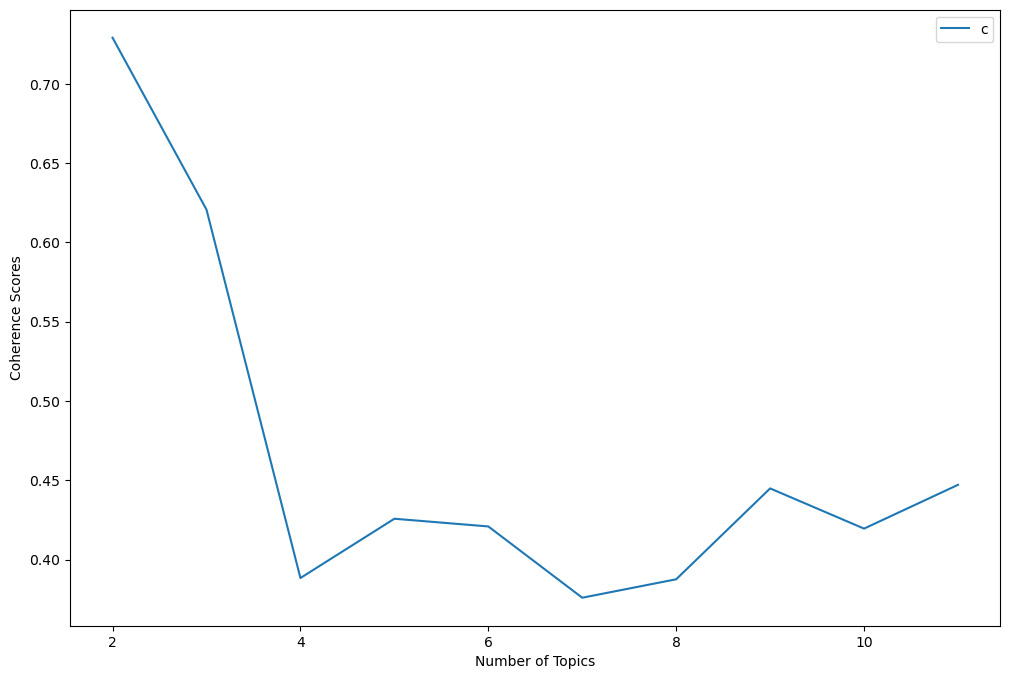

In [134]:
get_coherence_scores(corpus_tfidf_fake, dictionary_fake, fake_news_text, min_topics=2, max_topics=11)

In [136]:
lsa_model = LsiModel(corpus_tfidf_fake, id2word=dictionary_fake, num_topics=9)

In [138]:
lsa_model.print_topics()

[(0,
  '0.190*"trump" + 0.136*"clinton" + 0.095*"hillary" + 0.094*"obama" + 0.089*"president" + 0.087*"woman" + 0.078*"republican" + 0.077*"party" + 0.077*"flynn" + 0.074*"candidate"'),
 (1,
  '-0.325*"boiler" + -0.284*"acr" + -0.244*"room" + -0.240*"pm" + -0.186*"broadcast" + -0.180*"radio" + -0.142*"tune" + -0.142*"animal" + -0.134*"jay" + -0.132*"episode"'),
 (2,
  '0.623*"flynn" + 0.182*"immunity" + 0.122*"nana" + 0.116*"mr" + 0.110*"30" + 0.108*"march" + 0.102*"russian" + 0.100*"source" + -0.095*"school" + 0.092*"adviser"'),
 (3,
  '-0.217*"clinton" + 0.186*"school" + 0.176*"student" + -0.141*"hillary" + 0.121*"county" + 0.121*"flynn" + -0.110*"sander" + -0.098*"debate" + -0.097*"woman" + -0.091*"nominee"'),
 (4,
  '-0.200*"email" + 0.194*"trump" + -0.168*"dnc" + 0.142*"flynn" + -0.126*"clinton" + 0.112*"cruz" + -0.111*"department" + -0.110*"rich" + -0.102*"wikileaks" + -0.099*"sander"'),
 (5,
  '0.276*"student" + 0.160*"conference" + 0.160*"school" + 0.137*"trump" + -0.125*"mccai

## Creating our classification model

In [141]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,positive


In [147]:
x = [','.join(map(str, l)) for l in data['text_clean']]
y = data['fake_or_factual']

In [149]:
countvec = CountVectorizer()

In [151]:
countvec_fit = countvec.fit_transform(x)

In [157]:
bag_of_words = pd.DataFrame(countvec_fit.toarray(), columns=countvec.get_feature_names_out())

In [159]:
x_train, x_test, y_train, y_test = train_test_split(bag_of_words, y, test_size=0.3)

In [163]:
lr = LogisticRegression(random_state=0).fit(x_train, y_train)

In [165]:
y_pred_lr = lr.predict(x_test)

In [167]:
accuracy_score(y_pred_lr, y_test)

0.9

In [169]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

Factual News       0.88      0.94      0.91        31
   Fake News       0.93      0.86      0.89        29

    accuracy                           0.90        60
   macro avg       0.90      0.90      0.90        60
weighted avg       0.90      0.90      0.90        60



In [171]:
svm = SGDClassifier().fit(x_train, y_train)

In [173]:
y_pred_svm = svm.predict(x_test)

In [175]:
accuracy_score(y_pred_svm, y_test)

0.85

In [177]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

Factual News       0.84      0.87      0.86        31
   Fake News       0.86      0.83      0.84        29

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60

